In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


In [9]:
import torch #Core Framework
import torch.nn as nn #Neural Network
import torch.optim as optim #Optimizer
import torchvision #datasets+transforms
import torchvision.transforms as transforms
from torch.utils.data import DataLoader #batching
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [10]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
BATCH_SIZE = 128
EPOCHS = 30
LR = 0.001

In [12]:
# DATA AUGMENTATION
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


In [13]:
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)


In [14]:
print(train_dataset.classes)
print(len(train_dataset.classes))


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
10


In [15]:
from collections import Counter

labels = [label for _, label in train_dataset]
print(Counter(labels))


Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


In [16]:
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            
            
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x



    


In [18]:
model=CNN().to(device)

In [19]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [20]:
best_acc = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    scheduler.step()
    
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    
    acc = 100 * correct / total
    
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_model.pth")
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Loss: {train_loss/len(train_loader):.4f} "
          f"Val Acc: {acc:.2f}%")


Epoch [1/30] Loss: 1.7179 Val Acc: 51.60%
Epoch [2/30] Loss: 1.2933 Val Acc: 64.57%
Epoch [3/30] Loss: 1.1231 Val Acc: 62.95%
Epoch [4/30] Loss: 1.0062 Val Acc: 70.26%
Epoch [5/30] Loss: 0.9162 Val Acc: 73.99%
Epoch [6/30] Loss: 0.8315 Val Acc: 76.13%
Epoch [7/30] Loss: 0.7666 Val Acc: 79.67%
Epoch [8/30] Loss: 0.7136 Val Acc: 81.11%
Epoch [9/30] Loss: 0.6725 Val Acc: 80.27%
Epoch [10/30] Loss: 0.6260 Val Acc: 81.37%
Epoch [11/30] Loss: 0.5325 Val Acc: 82.54%
Epoch [12/30] Loss: 0.5017 Val Acc: 85.08%
Epoch [13/30] Loss: 0.4820 Val Acc: 86.12%
Epoch [14/30] Loss: 0.4655 Val Acc: 85.99%
Epoch [15/30] Loss: 0.4429 Val Acc: 86.27%
Epoch [16/30] Loss: 0.4317 Val Acc: 86.63%
Epoch [17/30] Loss: 0.4131 Val Acc: 85.89%
Epoch [18/30] Loss: 0.4023 Val Acc: 87.22%
Epoch [19/30] Loss: 0.3898 Val Acc: 86.62%
Epoch [20/30] Loss: 0.3748 Val Acc: 86.23%
Epoch [21/30] Loss: 0.3322 Val Acc: 88.34%
Epoch [22/30] Loss: 0.3240 Val Acc: 88.20%
Epoch [23/30] Loss: 0.3108 Val Acc: 88.13%
Epoch [24/30] Loss: 

In [21]:
print(f"Validation Accuracy after 30 epochs: {best_acc:.2f}%")

Validation Accuracy after 30 epochs: 89.11%


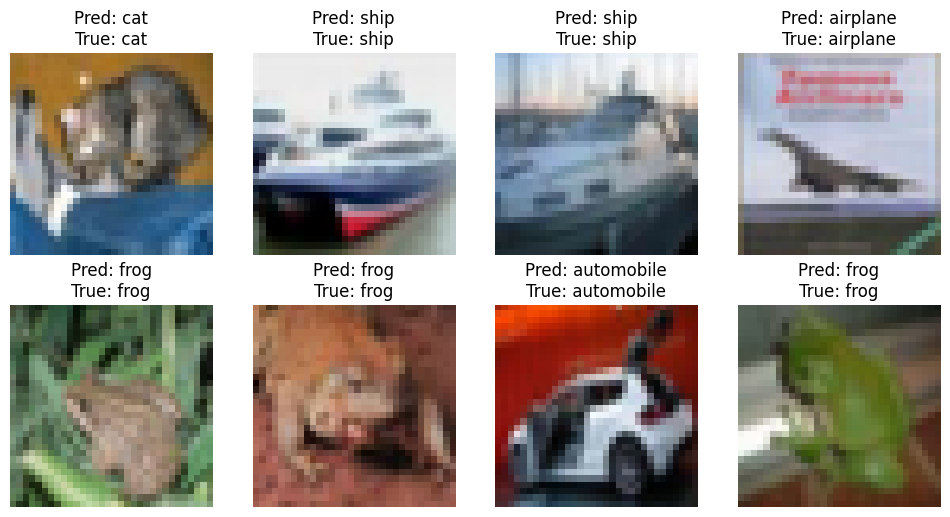

In [22]:
import numpy as np

classes = test_dataset.classes

model.eval()
images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

images = images.cpu()

plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    img = images[i] / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
    plt.axis("off")

plt.show()
